큐러닝의 큐함수 업데이트식
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha (R_{t+1} + \gamma \max_{a^\prime}Q(S_{t+1},a^\prime)-Q(S_t,A_t))
$$

DQN의 오류함수
$$
MSE = (\text{정답 } - \text{ 예측})^2 = (R_{t+1} + \gamma \max_{s^\prime} Q(s^\prime, a^\prime, \theta) - Q(s, a, \theta))^2
$$

타깃 네트워크를 이용한 DQN의 오류함수
$$
MSE = (\text{정답 } - \text{ 예측})^2 = (R_{t+1} + \gamma \max_{s^\prime} Q(s^\prime, a^\prime, \theta^-) - Q(s, a, \theta))^2
$$

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

In [3]:
EPISODE = 300

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        
        self.memory = deque(maxlen=2000)
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        
        self.update_target_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
        
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
            
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)
        
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))
                
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)             

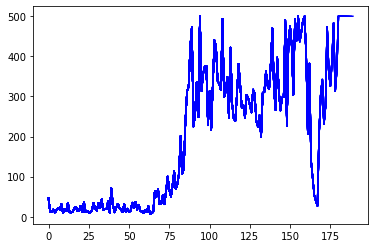

In [5]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)

scores, episodes = [], []
done_train = False

for e in range(EPISODE):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, -1])
    
    while not done:
        if agent.render:
            env.render()
        
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, -1])
        reward = reward if not done or score == 499 else -100
        
        agent.append_sample(state, action, reward, next_state, done)
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            
        score += reward
        state = next_state
        
        if done:
            agent.update_target_model()
            
            score = score if score == 500 else score + 100
            scores.append(score)
            episodes.append(e)
            
            pylab.plot(episodes, scores, 'b')
            pylab.savefig('./cartpole_dqn.png')
            
            if np.mean(scores[-min(10, len(scores)):]) > 490:
                done_train = True
                
    if done_train:
        break